## Installing Dependencies

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"geoffreysie","key":"73e815baeda51ff31d7d1606eafe9057"}'}

In [ ]:
! mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/titanic.zip -d /content/sample_data

Archive:  /content/titanic.zip
replace /content/sample_data/gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/sample_data/gender_submission.csv  
replace /content/sample_data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/sample_data/test.csv  
replace /content/sample_data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/sample_data/train.csv  


In [ ]:
! pip install ydata-profiling

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

In [ ]:
train_df = pd.read_csv('/content/sample_data/train.csv')
test_df = pd.read_csv('/content/sample_data/test.csv')

%matplotlib inline


## References
[1] [Ken Jee], ["Titianic Project Example"](https://www.kaggle.com/code/kenjee/titanic-project-example), Kaggle, Accessed on [25/03/2024].

[2] [Niklas Donges], ["Predicting the Survival of Titanic Passengers"](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8), Medium, Accessed on [26/03/2024].

[3] [IBRAHEM ALHUSSEINE], ["Titanic_model_with_98%_accuracy"](https://www.kaggle.com/code/ibrahemalhusseine/titanic-model-with-98-accuracy), Kaggle, Accessed on [26/03/2024].

## Exploratory Data Analysis

### Understand nature of the data
- `.info()`
- `.describe()`

### Visualizations
- Histograms and boxplots
- Value counts

### Missing data
- Check for missing values

### Correlation between the metrics
- Explore correlations

### Interesting themes to explore
- Do the wealthy survive?
- Survival by location
- Age scatterplot with ticket price
- Young and wealthy variable?
- Total spent?

## Feature Engineering
- Preprocess data together or use a transformer?
- Use label for train and test
- Scaling?

## Modeling
### Baseline Model
- Choose a baseline model

### Model Comparison
- Perform model comparison with cross-validation

In [ ]:
profile = ProfileReport(train_df, title="Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

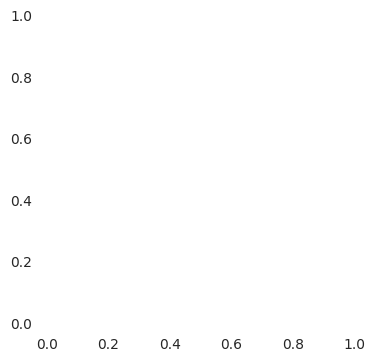

In [ ]:
profile

In [ ]:
train_df.info()

In [ ]:
train_df.describe()

In [ ]:
train_df.columns

In [ ]:
#quick way to separate numeric columns
train_df.describe().columns

In [ ]:
# Split into categoric and numeric
df_num = train_df[['Age','SibSp','Parch','Fare']]
df_cat = train_df[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

In [ ]:
#distributions for all numeric variables
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

In [ ]:
print(df_num.corr())
sns.heatmap(df_num.corr())

In [ ]:
# compare survival rate across Age, SibSp, Parch, and Fare
pd.pivot_table(train_df, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

In [ ]:
for i in df_cat.columns:
    sns.barplot(x = df_cat[i].value_counts().index, y = df_cat[i].value_counts()).set_title(i)
    plt.show()

## Feature Engineering

In [ ]:
# Comparing survival and each of these categorical variables
print(pd.pivot_table(train_df, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train_df, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train_df, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


### Cabin

In [ ]:
train_df['cabin_multiple'] = train_df['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
test_df['cabin_multiple'] = test_df['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
# after looking at this, we may want to look at cabin by letter or by number. Let's create some categories for this
# letters
# multiple letters
train_df['cabin_multiple'].value_counts()

cabin_multiple
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64

Looking to see if multiple cabins had an impact of survival rate

In [ ]:
pd.pivot_table(train_df, index = 'Survived', columns = 'cabin_multiple', values = 'Ticket' ,aggfunc ='count')

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


To fill out missing values in cabin, I will use a technique by <a href="https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8" target="_blank">Niklas Dongos</a>

In [ ]:
import re

# Define the deck level dictionary
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

# Create a list of datasets
data = [train_df, test_df]

for dataset in data:
    # Fill missing Cabin values with 'U0'
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")

    # Extract the first sequence of letters which represents the deck and map it to a number
    dataset['deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['deck'] = dataset['deck'].map(deck)

    # Fill missing deck values with 0
    dataset['deck'] = dataset['deck'].fillna(0)

    # Convert deck to an integer type
    dataset['deck'] = dataset['deck'].astype(int)

    # Drop the Cabin column as it's no longer needed
    dataset.drop(['Cabin'], axis=1, inplace=True)

### Relatives

In [ ]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

not_alone
1    537
0    354
Name: count, dtype: int64

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,cabin_multiple,deck,relatives,not_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,8,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,3,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,8,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,3,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,8,0,1


### Age

In [ ]:
for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,cabin_multiple,deck,relatives,not_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,0,8,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,1,3,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,0,8,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,1,3,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,0,8,0,1


### Title

In [ ]:
for dataset in data:
  dataset['title'] = dataset['Name'].apply(lambda x : x.split(',')[1].split('.')[0])

train_df['title'].value_counts()

title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [ ]:
# Drop passenger id and name for training set
train_df = train_df.drop(['PassengerId', 'Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

### Ticket

In [ ]:
#understand ticket values better
#numeric vs non numeric
train_df['numeric_ticket'] = train_df.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
train_df['ticket_letters'] = train_df.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [ ]:
train_df['numeric_ticket'].value_counts()

numeric_ticket
1    661
0    230
Name: count, dtype: int64

In [ ]:
#lets us view all rows in dataframe through scrolling. This is for convenience
#pd.set_option("max_rows", None)
train_df['ticket_letters'].value_counts()

ticket_letters
0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
fcc            5
c              5
sopp           3
pp             3
wep            3
ppp            2
scah           2
sotono2        2
swpp           2
fc             1
scahbasle      1
as             1
sp             1
sc             1
scow           1
fa             1
sop            1
sca4           1
casoton        1
Name: count, dtype: int64

In [ ]:
#difference in numeric vs non-numeric tickets in survival rate
pd.pivot_table(train_df,index='Survived',columns='numeric_ticket', values = 'Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [ ]:
#survival rate across different tyicket types
pd.pivot_table(train_df,index='Survived',columns='ticket_letters', values = 'Ticket', aggfunc='count')

ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


As ticket appears to not have any impact, I will drop it

In [ ]:
train_df = train_df.drop(['numeric_ticket','Ticket','ticket_letters'],axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [ ]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_multiple,deck,relatives,not_alone,title
0,0,3,male,22,1,0,7.2500,S,0,8,1,0,Mr
1,1,1,female,38,1,0,71.2833,C,1,3,1,0,Mrs
2,1,3,female,26,0,0,7.9250,S,0,8,0,1,Miss
3,1,1,female,35,1,0,53.1000,S,1,3,1,0,Mrs
4,0,3,male,35,0,0,8.0500,S,0,8,0,1,Mr


In [ ]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_multiple,deck,relatives,not_alone,title
0,0,3,male,22,1,0,7.2500,S,0,8,1,0,Mr
1,1,1,female,38,1,0,71.2833,C,1,3,1,0,Mrs
2,1,3,female,26,0,0,7.9250,S,0,8,0,1,Miss
3,1,1,female,35,1,0,53.1000,S,1,3,1,0,Mrs
4,0,3,male,35,0,0,8.0500,S,0,8,0,1,Mr


In [ ]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_multiple,deck,relatives,not_alone,title
0,0,3,male,22,1,0,7.2500,S,0,8,1,0,Mr
1,1,1,female,38,1,0,71.2833,C,1,3,1,0,Mrs
2,1,3,female,26,0,0,7.9250,S,0,8,0,1,Miss
3,1,1,female,35,1,0,53.1000,S,1,3,1,0,Mrs
4,0,3,male,35,0,0,8.0500,S,0,8,0,1,Mr


In [ ]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_multiple,deck,relatives,not_alone,title
0,892,3,male,22,0,0,7.8292,Q,0,8,0,1,Mr
1,893,3,female,38,1,0,7.0000,S,0,8,1,0,Mrs
2,894,2,male,26,0,0,9.6875,Q,0,8,0,1,Mr
3,895,3,male,35,0,0,8.6625,S,0,8,0,1,Mr
4,896,3,female,35,1,1,12.2875,S,0,8,2,0,Mrs


## Data Preprocesssing

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    int64  
 1   Pclass          891 non-null    int64  
 2   Sex             891 non-null    object 
 3   Age             891 non-null    int64  
 4   SibSp           891 non-null    int64  
 5   Parch           891 non-null    int64  
 6   Fare            891 non-null    float64
 7   Embarked        889 non-null    object 
 8   cabin_multiple  891 non-null    int64  
 9   deck            891 non-null    int64  
 10  relatives       891 non-null    int64  
 11  not_alone       891 non-null    int64  
 12  title           891 non-null    object 
dtypes: float64(1), int64(9), object(3)
memory usage: 90.6+ KB


In [ ]:

# for handel the category columns we will used one hot encoder
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_multiple,deck,relatives,not_alone,title
0,892,3,male,22,0,0,7.8292,Q,0,8,0,1,Mr
1,893,3,female,38,1,0,7.0000,S,0,8,1,0,Mrs
2,894,2,male,26,0,0,9.6875,Q,0,8,0,1,Mr
3,895,3,male,35,0,0,8.6625,S,0,8,0,1,Mr
4,896,3,female,35,1,1,12.2875,S,0,8,2,0,Mrs


In [ ]:
y_train = train_df["Survived"]
X_train = train_df.drop("Survived", axis=1)
passenger_id = test_df["PassengerId"]
X_test  = test_df.drop(["PassengerId"], axis=1).copy()


In [ ]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_multiple,deck,relatives,not_alone,title
0,3,male,22,0,0,7.8292,Q,0,8,0,1,Mr
1,3,female,38,1,0,7.0000,S,0,8,1,0,Mrs
2,2,male,26,0,0,9.6875,Q,0,8,0,1,Mr
3,3,male,35,0,0,8.6625,S,0,8,0,1,Mr
4,3,female,35,1,1,12.2875,S,0,8,2,0,Mrs


In [ ]:
nan_counts = X_test.isnull().sum()

# Print the number of NaN values for each column
print("Number of NaN values in each column of X_test:")
print(nan_counts)

Number of NaN values in each column of X_test:
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              1
Embarked          0
cabin_multiple    0
deck              0
relatives         0
not_alone         0
title             0
dtype: int64


In [ ]:
# Impute NaN values with mean for numerical columns
X_test = X_test.fillna(X_test.mean())

# Impute NaN values with most frequent category for categorical columns
X_test = X_test.fillna(X_test.mode().iloc[0])

In [ ]:
object_cols = ['Sex', 'Embarked', 'title']

In [ ]:
from sklearn.preprocessing import LabelEncoder

combined_data = pd.concat([X_train, X_test])

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoder to each categorical column
for column in object_cols:
    label_encoder.fit(combined_data[column])

    X_train[column] = label_encoder.transform(X_train[column])
    X_test[column] = label_encoder.transform(X_test[column])

In [ ]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

# Ensure all columns have string type
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

X_train.head()

In [ ]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_multiple,deck,relatives,not_alone,title
0,3,1,22,0,0,7.8292,1,0,8,0,1,12
1,3,0,38,1,0,7.0000,2,0,8,1,0,13
2,2,1,26,0,0,9.6875,1,0,8,0,1,12
3,3,1,35,0,0,8.6625,2,0,8,0,1,12
4,3,0,35,1,1,12.2875,2,0,8,2,0,13


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from yellowbrick.classifier import confusion_matrix as yell_con
from yellowbrick.classifier import ROCAUC

In [ ]:
#list of classifier
class_dict={
    'AdaBoostClassifier':AdaBoostClassifier(),
    'BaggingClassifier':BaggingClassifier(),
    'RandomForestClassifier':RandomForestClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(),
    'SVC':SVC(),
    'GradientBoostingClassifier':GradientBoostingClassifier(),
    'LogisticRegression':LogisticRegression(),
    'KNeighborsClassifier':KNeighborsClassifier(),
    'GaussianNB':GaussianNB(),
    'XGBClassifier':XGBClassifier()
}

classifiers_score=[]

for name,model in class_dict.items():
    kfold=KFold(n_splits=10,random_state=44,shuffle=True)
    cv_score=cross_val_score(model, X_train, y_train,cv=kfold, scoring='accuracy', error_score='raise')
    classifiers_score.append(cv_score.mean())
classifiers_df=pd.DataFrame({'classifier':class_dict.keys(), 'score':classifiers_score})

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
classifiers_df.sort_values(by='score')

,classifier,score
4,SVC,0.684682
7,KNeighborsClassifier,0.715031
8,GaussianNB,0.754207
3,DecisionTreeClassifier,0.755356
1,BaggingClassifier,0.798002
6,LogisticRegression,0.798015
2,RandomForestClassifier,0.807004
9,XGBClassifier,0.808127
5,GradientBoostingClassifier,0.817129
0,AdaBoostClassifier,0.818227


In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
# lr = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=75)
# svc = SVC(kernel='rbf', C=1.0, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
pip_step = []
pip_step.append(('gb', gb))
pipeline = Pipeline(steps=pip_step)
pipeline.fit(X_train, y_train)
pipeline.score(X_train, y_train)

0.9023569023569024

In [ ]:

predict_list=list(pipeline.predict(X_test))
predictions_df=pd.DataFrame({
    'PassengerId':passenger_id,
    'Survived':predict_list
})
predictions_df.to_csv('predictions.csv',index=False)